# 2. Evaluacion modelos de clasificacion binaria Redes LSTM
***


### Caso de estudio #3


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste de arquitectura | Si         |
| Sobremuestreo             | No          |
| Ajuste de pesos de clase  | No          |



In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns

from scipy.io import loadmat
import pandas_profiling

from numpy.random import seed
seed(0)

 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

keras.backend.clear_session()
import gc
gc.collect()

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
from keras import backend as K
from sklearn.metrics import classification_report

from matplotlib import pyplot

from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix




Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    print(matriz)
    
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

## Datos rodamiento en estado saludable

In [4]:
# importar datos de archivo matlab
HA1 = loadmat (r'D:\alexh\Documents\Maestria en estadistica\proyecto de grado\bases de datos vibraciones\rodamientos variando velocidad\datos de vibraciones\H-A-1.mat')

In [5]:
HA1

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 15:18:50 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[-0.00219944],
        [-0.0018706 ],
        [-0.00154175],
        ...,
        [ 0.00963905],
        [ 0.0093102 ],
        [ 0.00898136]]),
 'Channel_2': array([[4.18876708],
        [4.20060302],
        [4.20816487],
        ...,
        [0.03700339],
        [0.03634584],
        [4.14010822]])}

In [6]:
HA1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Channel_1', 'Channel_2'])

In [7]:
HA11=pd.DataFrame(HA1['Channel_1'], columns = ['aceleracion'])
HA11.head()

,aceleracion
0,-0.002199
1,-0.001871
2,-0.001542
3,-0.001871
4,-0.002199


In [8]:
HA12=pd.DataFrame(HA1['Channel_2'], columns = ['velocidad'])
HA12.head()

,velocidad
0,4.188767
1,4.200603
2,4.208165
3,4.226576
4,4.240385


In [9]:
# concatenar los dos DF

H1train = pd.concat([HA11, HA12], axis=1, sort=False)
H1train.head()

,aceleracion,velocidad
0,-0.002199,4.188767
1,-0.001871,4.200603
2,-0.001542,4.208165
3,-0.001871,4.226576
4,-0.002199,4.240385


In [10]:
print("numero de dimensiones =", H1train.ndim)
print("tamaño de la tabla  =", H1train.shape)
print("total datos =", H1train.size)

numero de dimensiones = 2
tamaño de la tabla  = (2000000, 2)
total datos = 4000000


In [11]:
#hallar si hay nul o NaN
H1train.isnull().any()

aceleracion    False
velocidad      False
dtype: bool

In [12]:
H1train.isna().any()

aceleracion    False
velocidad      False
dtype: bool

In [13]:
H1train.isnull().sum()

aceleracion    0
velocidad      0
dtype: int64

## Etiquetado de datos

In [14]:
H1train.head()

,aceleracion,velocidad
0,-0.002199,4.188767
1,-0.001871,4.200603
2,-0.001542,4.208165
3,-0.001871,4.226576
4,-0.002199,4.240385


In [15]:
H1train['falla'] = 0
H1train.head()

,aceleracion,velocidad,falla
0,-0.002199,4.188767,0
1,-0.001871,4.200603,0
2,-0.001542,4.208165,0
3,-0.001871,4.226576,0
4,-0.002199,4.240385,0


In [16]:
H1train.insert(0, 'id', 1)
H1train.head()

,id,aceleracion,velocidad,falla
0,1,-0.002199,4.188767,0
1,1,-0.001871,4.200603,0
2,1,-0.001542,4.208165,0
3,1,-0.001871,4.226576,0
4,1,-0.002199,4.240385,0


In [17]:
# importar datos de archivo matlab
HA3 = loadmat (r'D:\alexh\Documents\Maestria en estadistica\proyecto de grado\bases de datos vibraciones\rodamientos variando velocidad\datos de vibraciones\H-A-3.mat')

In [18]:
HA3

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 15:21:21 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[ 0.00174672],
        [ 0.00076018],
        [-0.00450137],
        ...,
        [ 0.02706795],
        [ 0.02969873],
        [ 0.02871218]]),
 'Channel_2': array([[0.03667461],
        [0.02812651],
        [0.03634584],
        ...,
        [4.27293377],
        [0.03700339],
        [0.03667461]])}

In [19]:
HA3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Channel_1', 'Channel_2'])

In [20]:
HA31=pd.DataFrame(HA3['Channel_1'], columns = ['aceleracion'])
HA31.head()

,aceleracion
0,0.001747
1,0.000760
2,-0.004501
3,0.000102
4,0.002404


In [21]:
HA32=pd.DataFrame(HA3['Channel_2'], columns = ['velocidad'])
HA32.head()

,velocidad
0,0.036675
1,0.028127
2,0.036346
3,0.036346
4,0.036017


In [22]:
# concatenar los dos DF

H3train = pd.concat([HA31, HA32], axis=1, sort=False)
H3train.head()

,aceleracion,velocidad
0,0.001747,0.036675
1,0.000760,0.028127
2,-0.004501,0.036346
3,0.000102,0.036346
4,0.002404,0.036017


In [23]:
print("numero de dimensiones =", H3train.ndim)
print("tamaño de la tabla  =", H3train.shape)
print("total datos =", H3train.size)

numero de dimensiones = 2
tamaño de la tabla  = (2000000, 2)
total datos = 4000000


In [24]:
#hallar si hay nul o NaN
H3train.isnull().any()

aceleracion    False
velocidad      False
dtype: bool

In [25]:
H3train.isna().any()

aceleracion    False
velocidad      False
dtype: bool

In [26]:
H3train.isnull().sum()

aceleracion    0
velocidad      0
dtype: int64

## Etiquetado de datos

In [27]:
H3train.head()

,aceleracion,velocidad
0,0.001747,0.036675
1,0.000760,0.028127
2,-0.004501,0.036346
3,0.000102,0.036346
4,0.002404,0.036017


In [28]:
H3train['falla'] = 0
H3train.head()

,aceleracion,velocidad,falla
0,0.001747,0.036675,0
1,0.000760,0.028127,0
2,-0.004501,0.036346,0
3,0.000102,0.036346,0
4,0.002404,0.036017,0


In [29]:
H3train.insert(0, 'id', 1)
H3train.head()

,id,aceleracion,velocidad,falla
0,1,0.001747,0.036675,0
1,1,0.000760,0.028127,0
2,1,-0.004501,0.036346,0
3,1,0.000102,0.036346,0
4,1,0.002404,0.036017,0


## Datos rodamiento con falla en pista interna

In [30]:
# importar datos de archivo matlab
IA1 = loadmat (r'D:\alexh\Documents\Maestria en estadistica\proyecto de grado\bases de datos vibraciones\rodamientos variando velocidad\datos de vibraciones\I-A-1.mat')

In [31]:
IA1

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 17:52:06 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[0.24871092],
        [0.24903977],
        [0.24838208],
        ...,
        [0.32927848],
        [0.26581098],
        [0.1648549 ]]),
 'Channel_2': array([[0.0379897 ],
        [0.03766093],
        [0.0379897 ],
        ...,
        [4.20684976],
        [4.22887776],
        [4.29200278]])}

In [32]:
IA1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Channel_1', 'Channel_2'])

In [33]:
IA11=pd.DataFrame(IA1['Channel_1'], columns = ['aceleracion'])
IA11.head()

,aceleracion
0,0.248711
1,0.249040
2,0.248382
3,0.250355
4,0.251013


In [34]:
IA12=pd.DataFrame(IA1['Channel_2'], columns = ['velocidad'])
IA12.head()

,velocidad
0,0.037990
1,0.037661
2,0.037990
3,0.037661
4,0.037332


In [35]:
# concatenar los dos DF

I1train = pd.concat([IA11, IA12], axis=1, sort=False)
I1train.head()

,aceleracion,velocidad
0,0.248711,0.037990
1,0.249040,0.037661
2,0.248382,0.037990
3,0.250355,0.037661
4,0.251013,0.037332


In [36]:
print("numero de dimensiones =", I1train.ndim)
print("tamaño de la tabla  =", I1train.shape)
print("total datos =", I1train.size)

numero de dimensiones = 2
tamaño de la tabla  = (2000000, 2)
total datos = 4000000


In [37]:
#hallar si hay nul o NaN
I1train.isnull().any()

aceleracion    False
velocidad      False
dtype: bool

In [38]:
I1train.isna().any()

aceleracion    False
velocidad      False
dtype: bool

In [39]:
I1train.isnull().sum()

aceleracion    0
velocidad      0
dtype: int64

## Etiquetado de datos

In [40]:
I1train.head()

,aceleracion,velocidad
0,0.248711,0.037990
1,0.249040,0.037661
2,0.248382,0.037990
3,0.250355,0.037661
4,0.251013,0.037332


In [41]:
I1train['falla'] = 1
I1train.head()

,aceleracion,velocidad,falla
0,0.248711,0.037990,1
1,0.249040,0.037661,1
2,0.248382,0.037990,1
3,0.250355,0.037661,1
4,0.251013,0.037332,1


In [42]:
I1train.insert(0, 'id', 1)
I1train.head()

,id,aceleracion,velocidad,falla
0,1,0.248711,0.037990,1
1,1,0.249040,0.037661,1
2,1,0.248382,0.037990,1
3,1,0.250355,0.037661,1
4,1,0.251013,0.037332,1


In [43]:
# importar datos de archivo matlab
IA3 = loadmat (r'D:\alexh\Documents\Maestria en estadistica\proyecto de grado\bases de datos vibraciones\rodamientos variando velocidad\datos de vibraciones\I-A-3.mat')

In [44]:
IA3

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 17:52:19 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[-0.01403794],
        [-0.007461  ],
        [-0.00252829],
        ...,
        [ 0.01818908],
        [-0.00088406],
        [ 0.00043133]]),
 'Channel_2': array([[0.03766093],
        [3.61998493],
        [4.17397216],
        ...,
        [4.25583741],
        [0.03733216],
        [0.03766093]])}

In [45]:
IA3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Channel_1', 'Channel_2'])

In [46]:
IA31=pd.DataFrame(IA3['Channel_1'], columns = ['aceleracion'])
IA31.head()

,aceleracion
0,-0.014038
1,-0.007461
2,-0.002528
3,0.000431
4,-0.002199


In [47]:
IA32=pd.DataFrame(IA3['Channel_2'], columns = ['velocidad'])
IA32.head()

,velocidad
0,0.037661
1,3.619985
2,4.173972
3,4.198302
4,4.213425


In [48]:
# concatenar los dos DF

I3train = pd.concat([IA31, IA32], axis=1, sort=False)
I3train.head()

,aceleracion,velocidad
0,-0.014038,0.037661
1,-0.007461,3.619985
2,-0.002528,4.173972
3,0.000431,4.198302
4,-0.002199,4.213425


In [49]:
print("numero de dimensiones =", I3train.ndim)
print("tamaño de la tabla  =", I3train.shape)
print("total datos =", I3train.size)

numero de dimensiones = 2
tamaño de la tabla  = (2000000, 2)
total datos = 4000000


In [50]:
#hallar si hay nul o NaN
I3train.isnull().any()

aceleracion    False
velocidad      False
dtype: bool

In [51]:
I3train.isna().any()

aceleracion    False
velocidad      False
dtype: bool

In [52]:
I3train.isnull().sum()

aceleracion    0
velocidad      0
dtype: int64

## Etiquetado de datos

In [53]:
I3train.head()

,aceleracion,velocidad
0,-0.014038,0.037661
1,-0.007461,3.619985
2,-0.002528,4.173972
3,0.000431,4.198302
4,-0.002199,4.213425


In [54]:
I3train['falla'] = 1
I3train.head()

,aceleracion,velocidad,falla
0,-0.014038,0.037661,1
1,-0.007461,3.619985,1
2,-0.002528,4.173972,1
3,0.000431,4.198302,1
4,-0.002199,4.213425,1


In [55]:
I3train.insert(0, 'id', 1)
I3train.head()

,id,aceleracion,velocidad,falla
0,1,-0.014038,0.037661,1
1,1,-0.007461,3.619985,1
2,1,-0.002528,4.173972,1
3,1,0.000431,4.198302,1
4,1,-0.002199,4.213425,1


In [56]:
I3train.tail()

,id,aceleracion,velocidad,falla
1999995,1,0.081657,4.181863,1
1999996,1,0.053705,4.117094,1
1999997,1,0.018189,4.255837,1
1999998,1,-0.000884,0.037332,1
1999999,1,0.000431,0.037661,1


## Concatenar las bases entrenamiento

In [111]:
# concatenar
train=pd.concat([H1train, I3train], ignore_index=True)
train.head()

,id,aceleracion,velocidad,falla
0,1,-0.002199,4.188767,0
1,1,-0.001871,4.200603,0
2,1,-0.001542,4.208165,0
3,1,-0.001871,4.226576,0
4,1,-0.002199,4.240385,0


In [112]:
train.tail()

,id,aceleracion,velocidad,falla
3999995,1,0.081657,4.181863,1
3999996,1,0.053705,4.117094,1
3999997,1,0.018189,4.255837,1
3999998,1,-0.000884,0.037332,1
3999999,1,0.000431,0.037661,1


In [113]:
train.shape


(4000000, 4)

### Normalizado de datos

In [59]:
# normalizar datos
variables=['aceleracion','velocidad']

objetivo='falla'

In [114]:
# escalado de datos 

scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
train.head()

,id,aceleracion,velocidad,falla
0,1,0.484421,0.941317,0
1,1,0.484604,0.943925,0
2,1,0.484787,0.945591,0
3,1,0.484604,0.949648,0
4,1,0.484421,0.952691,0


In [115]:
train.tail()

,id,aceleracion,velocidad,falla
3999995,1,0.531158,0.939795,1
3999996,1,0.515579,0.925523,1
3999997,1,0.495784,0.956096,1
3999998,1,0.485154,0.026516,1
3999999,1,0.485887,0.026588,1


Tamaño de la base 4 millones de observaciones 

In [116]:
# borrar la columna id

train.drop('id', axis=1, inplace=True)
train.head()

,aceleracion,velocidad,falla
0,0.484421,0.941317,0
1,0.484604,0.943925,0
2,0.484787,0.945591,0
3,0.484604,0.949648,0
4,0.484421,0.952691,0


In [117]:
# separar datos de etiquetas

data_train=train.iloc[:,np.r_[0:2]]
label_train=train.iloc[:,2]

In [118]:
label_train.head()

0    0
1    0
2    0
3    0
4    0
Name: falla, dtype: int64

In [119]:
# conteo de observaciones etiquetadas con 1 y 0 en la base train
label_train.value_counts(sort=False)

0    2000000
1    2000000
Name: falla, dtype: int64

In [120]:
data_train.head()

,aceleracion,velocidad
0,0.484421,0.941317
1,0.484604,0.943925
2,0.484787,0.945591
3,0.484604,0.949648
4,0.484421,0.952691


In [121]:
label_train.head()

0    0
1    0
2    0
3    0
4    0
Name: falla, dtype: int64

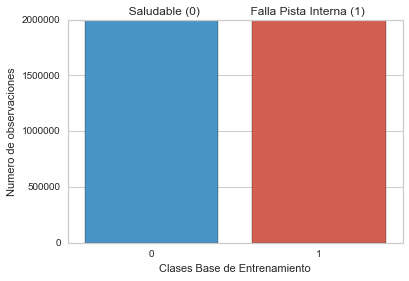

In [122]:
# grafica de clases base de train, estado base equilibrada
sns.countplot(label_train, palette=["#3498db", "#e74c3c"])
plt.title('       Saludable (0)               Falla Pista Interna (1)')
plt.xlabel("Clases Base de Entrenamiento")
plt.ylabel("Numero de observaciones")
plt.savefig('vibraciones entrenamientoapp.png')
pyplot.show()

## Concatenar las bases de prueba

In [123]:
# concatenar
test=pd.concat([H3train, I1train], ignore_index=True)
test.head()

,id,aceleracion,velocidad,falla
0,1,0.001747,0.036675,0
1,1,0.000760,0.028127,0
2,1,-0.004501,0.036346,0
3,1,0.000102,0.036346,0
4,1,0.002404,0.036017,0


In [124]:
test.tail()

,id,aceleracion,velocidad,falla
3999995,1,0.408531,0.037332,1
3999996,1,0.371371,4.076983,1
3999997,1,0.329278,4.206850,1
3999998,1,0.265811,4.228878,1
3999999,1,0.164855,4.292003,1


In [125]:
test.shape


(4000000, 4)

In [126]:
# normalizado de datos sin incluir id, ciclo, ttf y clase

test[variables]=scaler.transform(test[variables])

Tamaño de la base 4 millones de observaciones 

In [127]:
# borrar la columna id

test.drop('id', axis=1, inplace=True)
test.head()

,aceleracion,velocidad,falla
0,0.486620,0.026371,0
1,0.486070,0.024487,0
2,0.483138,0.026299,0
3,0.485704,0.026299,0
4,0.486987,0.026226,0


In [128]:
# separar datos de etiquetas

data_test=test.iloc[:,np.r_[0:2]]
label_test=test.iloc[:,2]

In [129]:
label_test.head()

0    0
1    0
2    0
3    0
4    0
Name: falla, dtype: int64

In [130]:
# conteo de observaciones etiquetadas con 1 y 0 en la base train
label_test.value_counts(sort=False)

0    2000000
1    2000000
Name: falla, dtype: int64

In [131]:
data_test.head()

,aceleracion,velocidad
0,0.486620,0.026371
1,0.486070,0.024487
2,0.483138,0.026299
3,0.485704,0.026299
4,0.486987,0.026226


In [132]:
label_test.head()

0    0
1    0
2    0
3    0
4    0
Name: falla, dtype: int64

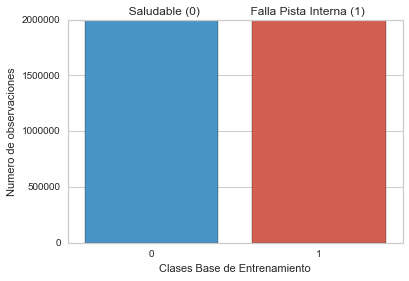

In [133]:
# grafica de clases base de train, estado base equilibrada
sns.countplot(label_test, palette=["#3498db", "#e74c3c"])
plt.title('       Saludable (0)               Falla Pista Interna (1)')
plt.xlabel("Clases Base de Entrenamiento")
plt.ylabel("Numero de observaciones")
plt.savefig('vibraciones entrenamientoapp.png')
pyplot.show()

### Convertir en formato 3D

In [134]:
# convertir en arreglo
data_train2=data_train.to_numpy()

In [135]:
type(data_train2)

numpy.ndarray

In [136]:
data_train2

array([[0.48442065, 0.9413168 ],
       [0.48460393, 0.94392494],
       [0.48478721, 0.94559126],
       ...,
       [0.49578428, 0.95609627],
       [0.48515378, 0.02651587],
       [0.48588692, 0.02658831]])

In [138]:
# covertir datos de 2d a 3d como lo requiere LSTM
data_train = data_train2.reshape((data_train2.shape[0], 1, data_train2.shape[1]))

In [139]:
data_train.shape

(4000000, 1, 2)

In [140]:
data_train

array([[[0.48442065, 0.9413168 ]],

       [[0.48460393, 0.94392494]],

       [[0.48478721, 0.94559126]],

       ...,

       [[0.49578428, 0.95609627]],

       [[0.48515378, 0.02651587]],

       [[0.48588692, 0.02658831]]])

In [141]:
label_train=label_train.to_numpy()

In [142]:
label_train.shape

(4000000,)

In [143]:
data_test2=data_test.to_numpy()

In [144]:
data_test = data_test2.reshape((data_test2.shape[0], 1, data_test2.shape[1]))

In [145]:
data_test.shape

(4000000, 1, 2)

In [146]:
label_test=label_test.to_numpy()

In [147]:
label_test.shape

(4000000,)

In [148]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)

numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (4000000, 1, 2)
total datos Data_train = 8000000
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (4000000,)
total datos Label_train = 4000000
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (4000000, 1, 2)
total datos Data_test = 8000000
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (4000000,)
total datos Label_test = 4000000


## Stacked LSTM (APILADO)

In [160]:
model_path_clf = 'classification_model6.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(100, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# entrenar modelo
history = model.fit(data_train, label_train, epochs=20, batch_size=128, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 100)            41200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 71,451
Trainable params: 71,451
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600000 s

In [161]:
# cargar el mejor modelo guardado durante el entrenamiento

# load the saved model
saved_model = load_model('classification_model6.h5')

In [162]:
label_pred=saved_model.predict_classes(data_test)

In [163]:
# Medidas de desempeño del modelo
matriz = confusion_matrix(label_test, label_pred)
print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
print('\n')
print("MEDIDAS DE DESEMPEÑO DEL MODELO")
print('\n')
print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
print('-'*60)
print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
print('-'*60)
print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))

Confusion Matrix: 
 [[1694634  305366]
 [   2849 1997151]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.92294625
ROC AUC: 0.92294625
------------------------------------------------------------
Precisión por clase: [0.99832163 0.86737731]
Sensibilidad - Recall por clase: [0.847317  0.9985755]
F1 por clase: [0.91664194 0.92836403]
------------------------------------------------------------
F1 Macro: 0.9225029838491651
F1 Micro: 0.92294625
F1 Weighted: 0.9225029838491651
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.92294625
Sensibilidad - Recall Micro: 0.92294625
Sensibilidad - Recall Weighted: 0.92294625
------------------------------------------------------------
Precisión Macro: 0.9328494709712412
Precisión Micro: 0.92294625
Precisión Weighted: 0.9328494709712412


## Vanilla LSTM

## Busqueda del numero de celdas de memoria red LSTM

A continuacion se relizara una busqueda del numero optimo de celdas de memoria 


In [104]:
# Funcion para entrenar modelo LSTM
def fit_model(n_cells):
   # definir el modelo
    model = Sequential()
    model.add(LSTM(n_cells, input_shape=(time_steps, features)))
    model.add(Dense(1, activation='sigmoid' ))
    # compilar el modelo
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # entrenar el modelo
    history = model.fit(data_train, label_train, epochs=5, batch_size=512, shuffle=False, verbose=2)
    # evaluar el modelo
    loss = model.evaluate(data_test, label_test, verbose=0)
    return loss

Epoch 1/5
 - 50s - loss: 0.0695
Epoch 2/5
 - 49s - loss: 0.0789
Epoch 3/5
 - 44s - loss: 0.0671
Epoch 4/5
 - 44s - loss: 0.0619
Epoch 5/5
 - 44s - loss: 0.0591
>1/2 param=30.000000, loss=3.991799
Epoch 1/5
 - 46s - loss: 0.0700
Epoch 2/5
 - 48s - loss: 0.0810
Epoch 3/5
 - 45s - loss: 0.0732
Epoch 4/5
 - 47s - loss: 0.0685
Epoch 5/5
 - 45s - loss: 0.0667
>2/2 param=30.000000, loss=3.821061
Epoch 1/5
 - 45s - loss: 0.0617
Epoch 2/5
 - 44s - loss: 0.0714
Epoch 3/5
 - 44s - loss: 0.0573
Epoch 4/5
 - 45s - loss: 0.0446
Epoch 5/5
 - 48s - loss: 0.0367
>1/2 param=50.000000, loss=4.882663
Epoch 1/5
 - 46s - loss: 0.0593
Epoch 2/5
 - 45s - loss: 0.0722
Epoch 3/5
 - 45s - loss: 0.0590
Epoch 4/5
 - 45s - loss: 0.0495
Epoch 5/5
 - 45s - loss: 0.0402
>2/2 param=50.000000, loss=4.767308
Epoch 1/5
 - 47s - loss: 0.0478
Epoch 2/5
 - 46s - loss: 0.0583
Epoch 3/5
 - 47s - loss: 0.0419
Epoch 4/5
 - 45s - loss: 0.0325
Epoch 5/5
 - 45s - loss: 0.0293
>1/2 param=100.000000, loss=5.264175
Epoch 1/5
 - 47s - 

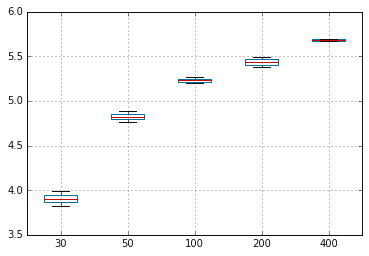

In [105]:
# realizar la evalaucion del desempeño de la red con cadas 7 configuraciones de celdas de memoria
# debido a la naturaleza estocastica de las red LSTM se repete el experimento 10 veces por cada grupo de celdas de memoria

features =data_train.shape[2]
time_steps =data_train.shape[1]

# definir el alcance de la búsqueda
params = [30, 50, 100, 200, 400]
n_repeats = 2

# valores de parámetros de búsqueda de cuadrícula
scores = DataFrame()

for value in params:
    # repite cada experimento varias veces
    loss_values = list()
    for i in range(n_repeats):
        loss = fit_model(value)
        loss_values.append(loss)
        print( '>%d/%d param=%f, loss=%f' % (i+1, n_repeats, value, loss))
    # almacenar resultados para este parámetro
    scores[str(value)] = loss_values

# estadísticas resumidas de resultados
print(scores.describe())

# grafica de cajas y bigotes de los resultados
scores.boxplot()
#pyplot.show()

# Vanilla LSTM ajustado

In [106]:

model_path_clf = 'classification_modelv2.h5'  
nb_features =data_train.shape[2]
timestamp=data_train.shape[1]


modelolstmv = Sequential()
modelolstmv.add(LSTM(30,input_shape=(timestamp, nb_features)))
modelolstmv.add(Dense(units=1, activation='sigmoid'))
modelolstmv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelolstmv.summary())

# entrenar modelo
history = modelolstmv.fit(data_train, label_train, epochs=20, batch_size=64, validation_split=0.1, verbose=2, 
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30)                3960      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 31        
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600000 samples, validate on 400000 samples
Epoch 1/20
 - 338s - loss: 0.6870 - acc: 0.5555 - val_loss: 0.8086 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.80859, saving model to classification_modelv2.h5
Epoch 2/20
 - 341s - loss: 0.6751 - acc: 0.5807 - val_loss: 0.7201 - val_acc: 0.3405

Epoch 00002: val_loss improved from 0.80859 to 0.72005, saving model to classification_modelv2.h5
Epoch 3/20
 - 341s - loss: 0.5985 - acc: 0.7093 - val_loss: 0.5123 - val_acc: 0.6472

Epoch 00003: val_loss im

In [107]:
# cargar el mejor modelo guardado durante el entrenamiento

saved_model = load_model('classification_modelv2.h5')

In [108]:
label_pred=saved_model.predict_classes(data_test)

In [109]:
# Medidas de desempeño del modelo
matriz = confusion_matrix(label_test, label_pred)
print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
print('\n')
print("MEDIDAS DE DESEMPEÑO DEL MODELO")
print('\n')
print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
print('-'*60)
print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
print('-'*60)
print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))

Confusion Matrix: 
 [[1691614  308386]
 [   2830 1997170]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.922196
ROC AUC: 0.9221959999999999
------------------------------------------------------------
Precisión por clase: [0.99832984 0.86624224]
Sensibilidad - Recall por clase: [0.845807 0.998585]
F1 por clase: [0.91576107 0.92771758]
------------------------------------------------------------
F1 Macro: 0.9217393271138599
F1 Micro: 0.922196
F1 Weighted: 0.92173932711386
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.922196
Sensibilidad - Recall Micro: 0.922196
Sensibilidad - Recall Weighted: 0.922196
------------------------------------------------------------
Precisión Macro: 0.9322860391397978
Precisión Micro: 0.922196
Precisión Weighted: 0.9322860391397979


### Vanilla LSTM con 50 celdas de memoria

In [154]:

model_path_clf = 'classification_model7.h5'  
nb_features =data_train.shape[2]
timestamp=data_train.shape[1]


modelolstmv = Sequential()
modelolstmv.add(LSTM(50,input_shape=(timestamp, nb_features)))
modelolstmv.add(Dense(units=1, activation='sigmoid'))
modelolstmv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelolstmv.summary())

# entrenar modelo
history = modelolstmv.fit(data_train, label_train, epochs=20, batch_size=256, validation_split=0.1, verbose=2, 
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________
None
Train on 3600000 samples, validate on 400000 samples
Epoch 1/20
 - 82s - loss: 0.6870 - acc: 0.5555 - val_loss: 0.8044 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.80438, saving model to classification_model7.h5
Epoch 2/20
 - 81s - loss: 0.6868 - acc: 0.5560 - val_loss: 0.8045 - val_acc: 0.0221

Epoch 00002: val_loss did not improve from 0.80438
Epoch 3/20
 - 81s - loss: 0.6861 - acc: 0.5639 - val_loss: 0.8223 - val_acc: 0.0773

Epoch 00003: val_loss did not improve from 0.80438
Epoch 4/20
 - 82s - lo

In [155]:
# cargar el mejor modelo guardado durante el entrenamiento

saved_model = load_model('classification_model7.h5')

In [156]:
label_pred=saved_model.predict_classes(data_test)

In [157]:
# Medidas de desempeño del modelo
matriz = confusion_matrix(label_test, label_pred)
print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
print('\n')
print("MEDIDAS DE DESEMPEÑO DEL MODELO")
print('\n')
print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
print('-'*60)
print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
print('-'*60)
print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
print('-'*60)
print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))

Confusion Matrix: 
 [[1757990  242010]
 [   3121 1996879]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.93871725
ROC AUC: 0.93871725
------------------------------------------------------------
Precisión por clase: [0.99822782 0.89190621]
Sensibilidad - Recall por clase: [0.878995  0.9984395]
F1 por clase: [0.93482484 0.94217093]
------------------------------------------------------------
F1 Macro: 0.9384978875158819
F1 Micro: 0.93871725
F1 Weighted: 0.9384978875158819
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9387172500000001
Sensibilidad - Recall Micro: 0.93871725
Sensibilidad - Recall Weighted: 0.93871725
------------------------------------------------------------
Precisión Macro: 0.9450670160352204
Precisión Micro: 0.93871725
Precisión Weighted: 0.9450670160352205


<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

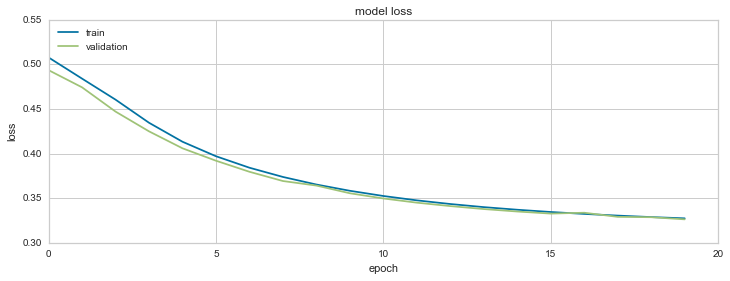

In [114]:
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

La curva de aprendizaje presenta buen ajuste, las redes neuronales profundas con arquitectura
LSTM entregan el mayor F1-macro con un 93.8%. En este caso se observa que el desempeño de los modelos de conjunto de ML se acerca a los modelos de redes neuronales profundas, esto se debe a que los modelos se entrenan con una base de datos equilibrada lo que ayuda a mejorar el rendimiento predictivo de los modelos clasicos de ML. 